In [ ]:
# Install core libraries for audio processing, array simulation, and plotting
!pip install numpy scipy matplotlib soundfile librosa plotly

# Explicitly upgrade pyroomacoustics to ensure latest version
!pip install --upgrade pyroomacoustics

# Install scikit-learn for model training and preprocessing
!pip install scikit-learn

# Install LightGBM (for potential future use if RandomForest isn't enough)
!pip install lightgbm

In [ ]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import pyroomacoustics as pra
import soundfile as sf
from scipy.linalg import eigh
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import librosa
import os # For file operations

# For sound classification model training and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV # Added GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd # To read the ESC-50 metadata CSV

# import lightgbm as lgb # For potential future use


# --- Helper Functions for MUSIC Algorithm (No Changes) ---

def compute_spatial_covariance_matrix(mic_data_stft_frame):
    """
    Computes the spatial covariance matrix for a single frequency bin's STFT data.
    Args:
        mic_data_stft_frame (np.ndarray): Complex STFT data for one frequency bin
                                         across all microphones. Shape: (n_mics,).
    Returns:
        np.ndarray: Spatial covariance matrix (n_mics, n_mics).
    """
    mic_data_stft_frame = mic_data_stft_frame.reshape(-1, 1)
    R = np.outer(mic_data_stft_frame, mic_data_stft_frame.conj().T)
    return R


def compute_steering_vector(mic_positions, array_center, source_angle_rad, freq, speed_of_sound=343.0):
    """
    Computes the steering vector (manifold vector) for a given microphone array
    geometry and source direction, relative to the array center.
    Args:
        mic_positions (np.ndarray): (3, n_mics) array of [x, y, z] coordinates of microphones (absolute).
        array_center (np.ndarray): (3,) array of [x, y, z] coordinates of the array's phase center.
        source_angle_rad (np.ndarray): [azimuth_rad, elevation_rad] of the source.
        freq (float): Frequency in Hz for which to compute the steering vector.
        speed_of_sound (float): Speed of sound in m/s.
    Returns:
        np.ndarray: Steering vector (n_mics,).
    """
    k = 2 * np.pi * freq / speed_of_sound

    azimuth, elevation = source_angle_rad

    u_x = np.cos(elevation) * np.cos(azimuth)
    u_y = np.cos(elevation) * np.sin(azimuth)
    u_z = np.sin(elevation)

    direction_vector = np.array([u_x, u_y, u_z]).reshape(3, 1)

    mic_positions_relative_to_center = mic_positions - array_center.reshape(3, 1)

    phase_shifts = +1j * k * np.dot(mic_positions_relative_to_center.T, direction_vector).flatten()

    a = np.exp(phase_shifts)
    return a


def music_algorithm(R, n_sources, mic_positions, array_center, Fs, freq, azimuth_range_deg, elevation_deg_range):
    """
    Implements the MUSIC algorithm for 3D Direction of Arrival (DOA) estimation.
    Args:
        R (np.ndarray): Spatial Covariance Matrix (n_mics, n_mics).
        n_sources (int): Number of expected sound sources.
        mic_positions (np.ndarray): (3, n_mics) array of microphone coordinates.
        array_center (np.ndarray): (3,) array of [x, y, z] coordinates of the array's phase center.
        Fs (int): Sampling frequency.
        freq (float): Frequency bin in Hz for analysis.
        azimuth_range_deg (np.ndarray): Array of azimuth angles (degrees) to search.
        elevation_deg_range (np.ndarray): Array of elevation angles (degrees) to search.
    Returns:
        np.ndarray: 2D MUSIC pseudospectrum (azimuth_len, elevation_len).
    """
    eigenvalues, eigenvectors = eigh(R)

    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    if n_sources >= eigenvectors.shape[1]:
        print("Warning: n_sources >= number of microphones. Cannot form noise subspace.")
        return np.zeros((len(azimuth_range_deg), len(elevation_deg_range)))

    Un = eigenvectors[:, n_sources:]

    P_music = np.zeros((len(azimuth_range_deg), len(elevation_deg_range)))

    for i, az_deg in enumerate(azimuth_range_deg):
        for j, el_deg in enumerate(elevation_deg_range):
            source_angle_rad = np.array([np.deg2rad(az_deg), np.deg2rad(el_deg)])
            a = compute_steering_vector(mic_positions, array_center, source_angle_rad, freq)

            denominator = np.real(np.dot(np.dot(a.conj().T, Un), np.dot(Un.conj().T, a)))

            if denominator < 1e-15:
                P_music[i, j] = np.inf
            else:
                P_music[i, j] = 1.0 / denominator

    return P_music

# --- Helper Function for Feature Extraction (for ESC-50 and input audio) ---
def extract_audio_features(audio_path, sr=16000, duration=5):
    """
    Extracts a richer set of audio features from an audio file.
    Args:
        audio_path (str or np.ndarray): Path to audio file or audio time series.
        sr (int): Sampling rate.
        duration (int): Duration in seconds to load (for consistency).
    Returns:
        np.ndarray: Flattened concatenated features (mean and variance).
    """
    if isinstance(audio_path, str):
        y, sr = librosa.load(audio_path, sr=sr, duration=duration)
    else: # Assume it's already an audio array
        y = audio_path

    # Pad/truncate audio to a consistent length
    target_length = sr * duration
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)), 'constant')
    elif len(y) > target_length:
        y = y[:target_length]

    features = []

    # 1. MFCCs (Mel-frequency cepstral coefficients)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    features.extend([np.mean(mfccs, axis=1), np.var(mfccs, axis=1)])

    # 2. Spectral Centroid
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    features.extend([np.mean(spectral_centroids), np.var(spectral_centroids)])

    # 3. Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    features.extend([np.mean(spectral_bandwidth), np.var(spectral_bandwidth)])

    # 4. Spectral Rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    features.extend([np.mean(spectral_rolloff), np.var(spectral_rolloff)])

    # 5. Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y=y)[0]
    features.extend([np.mean(zcr), np.var(zcr)])

    # 6. Chroma_stft (chroma features)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.extend([np.mean(chroma, axis=1), np.var(chroma, axis=1)])

    # 7. Root Mean Square Energy (RMSE)
    rmse = librosa.feature.rms(y=y)[0]
    features.extend([np.mean(rmse), np.var(rmse)])

    # Flatten and concatenate all features
    concatenated_features = np.hstack([f.flatten() for f in features])
    return concatenated_features

In [ ]:
# --- Configuration ---
Fs = 16000  # Sampling frequency in Hz (will resample uploaded audio to this)
n_mics = 6  # Number of microphones in our virtual array (must be >= 4 for 3D localization)
mic_radius = 0.08 # Radius of the circular arrangement in meters
mic_height = 1.2  # Base height of the array center from the ground in meters
delta_z = 0.02 # Small vertical displacement for 3D array (e.g., 2 cm)

# Room dimensions [x, y, z] in meters
room_dim = np.array([6, 5, 3])
room_center = room_dim / 2

# --- MANUAL GENERATION OF 3D CIRCULAR MICROPHONE ARRAY COORDINATES ---
mic_array_coords = np.zeros((3, n_mics))
for i in range(n_mics):
    angle = 2 * np.pi * i / n_mics # Angle for each microphone
    mic_array_coords[0, i] = room_center[0] + mic_radius * np.cos(angle) # x-coordinate
    mic_array_coords[1, i] = room_center[1] + mic_radius * np.sin(angle) # y-coordinate

    # Introduce Z-variation for 3D array
    if i % 2 == 0: # Even indexed mics slightly above
        mic_array_coords[2, i] = mic_height + delta_z
    else: # Odd indexed mics slightly below
        mic_array_coords[2, i] = mic_height - delta_z

# Create a MicrophoneArray object from the manually generated coordinates
mic_array = pra.MicrophoneArray(mic_array_coords, Fs)


# --- LOAD YOUR UPLOADED AUDIO FILE AS THE SOURCE SIGNAL ---
# IMPORTANT: Replace 'barking_dog.wav' with the actual filename you uploaded.
# For best classification results, use a 'dog' sample directly from the ESC-50 dataset,
# e.g., '1-100032-A-0.wav' after unzipping the ESC-50 dataset.
uploaded_audio_filename = '/content/ESC-50-master/audio/1-100038-A-14.wav' # <--- CHANGE THIS FILENAME

try:
    source_signal, original_sr = librosa.load(uploaded_audio_filename, sr=Fs)
    print(f"Loaded audio '{uploaded_audio_filename}' (Original SR: {original_sr} Hz, Resampled to: {Fs} Hz)")
    print(f"Source signal duration: {len(source_signal)/Fs:.2f} seconds")
except FileNotFoundError:
    print(f"ERROR: Audio file '{uploaded_audio_filename}' not found. Please upload it to Colab.")
    # Fallback to a simple sine wave if file not found, so the rest of the code can run
    signal_duration = 3.0
    t = np.linspace(0, signal_duration, int(Fs * signal_duration), endpoint=False)
    source_signal = 0.5 * np.sin(2 * np.pi * 500 * t) # Fallback sine wave
    print("Using a fallback sine wave as source signal.")
except Exception as e:
    print(f"ERROR loading audio file: {e}")
    signal_duration = 3.0
    t = np.linspace(0, signal_duration, int(Fs * signal_duration), endpoint=False)
    source_signal = 0.5 * np.sin(2 * np.pi * 500 * t) # Fallback sine wave
    print("Using a fallback sine wave as source signal due to loading error.")


# Define a single Sound Source Position (This is the *simulated* true position of the barking dog)
source_pos = np.array([1.5, 3.5, 1.8]) # [x, y, z] position of the simulated sound source

# --- Create Room and Simulate Audio ---
room = pra.ShoeBox(
    room_dim, # Pass room dimensions directly
    fs=Fs,
    max_order=0, # max_order=0 means no reverberation (anechoic chamber simulation)
)

# Add microphone array and source to the room
room.add_microphone_array(mic_array)
room.add_source(source_pos, signal=source_signal)

# Simulate the Room Impulse Responses (RIRs) and record the sound at microphones
room.simulate()

# Get the multi-channel microphone data. pyroomacoustics gives (n_mics, n_samples)
mic_data = room.mic_array.signals.T # Transpose to (n_samples, n_mics)

print(f"Simulated Microphone Data Shape: {mic_data.shape} (Samples, Mics)")
print(f"Sampling Frequency: {Fs} Hz")

from IPython.display import Audio
print("\nPlaying simulated audio (first channel):")
Audio(mic_data[:, 0], rate=Fs)

Loaded audio '/content/ESC-50-master/audio/1-100038-A-14.wav' (Original SR: 16000 Hz, Resampled to: 16000 Hz)
Source signal duration: 5.00 seconds
Simulated Microphone Data Shape: (80174, 6) (Samples, Mics)
Sampling Frequency: 16000 Hz

Playing simulated audio (first channel):


In [ ]:
# --- ESC-50 Dataset Preparation and Model Training ---

# Download ESC-50 dataset if not already present
esc50_zip_url = "https://github.com/karolpiczak/ESC-50/archive/master.zip"
esc50_dir = "ESC-50-master"
esc50_audio_dir = os.path.join(esc50_dir, "audio")
esc50_meta_file = os.path.join(esc50_dir, "meta", "esc50.csv")

if not os.path.exists(esc50_dir):
    print("Downloading ESC-50 dataset...")
    !wget {esc50_zip_url} -O esc50.zip
    !unzip -q esc50.zip
    print("ESC-50 dataset downloaded and unzipped.")
else:
    print("ESC-50 dataset already exists.")

# Load metadata
esc50_df = pd.read_csv(esc50_meta_file)
print(f"ESC-50 metadata loaded. Total samples: {len(esc50_df)}")

# Prepare data for training
features = []
labels = []
target_sr = Fs # Use the same sampling rate as our simulation

print("Extracting features from ESC-50 dataset (this may take a few minutes)...")
for index, row in esc50_df.iterrows():
    audio_file_path = os.path.join(esc50_audio_dir, row['filename'])
    try:
        audio_features = extract_audio_features(audio_file_path, sr=target_sr)
        features.append(audio_features)
        labels.append(row['category'])
    except Exception as e:
        print(f"Could not process {audio_file_path}: {e}")
        continue

features = np.array(features)
labels = np.array(labels)

print(f"Extracted {len(features)} feature vectors.")
print(f"Feature vector shape: {features.shape}")

# Encode labels to numerical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
print(f"Found {num_classes} classes: {label_encoder.classes_}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

# Scale features (important for many ML models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nPerforming GridSearchCV for RandomForestClassifier (this will take longer)...")
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300], # Number of trees
    'max_features': ['sqrt', 'log2'], # Number of features to consider at each split
    'max_depth': [10, 20, 30, None], # Maximum depth of the tree
    'min_samples_split': [2, 5] # Minimum number of samples required to split a node
}

# Initialize GridSearchCV
# cv=3 means 3-fold cross-validation
# n_jobs=-1 uses all available CPU cores
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2, # Print progress
    scoring='accuracy'
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

print("\nGridSearchCV complete.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.2f}")

# Use the best estimator found by GridSearchCV
esc50_classifier = grid_search.best_estimator_

print("Model training complete with best parameters.")

# Evaluate the trained model on the held-out test set
y_pred = esc50_classifier.predict(X_test_scaled)
print(f"\nModel Accuracy on Test Set (Best Estimator): {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report (Best Estimator):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Store the trained model and scaler for later use
# We will use esc50_classifier, label_encoder, and scaler in Cell 4.

ESC-50 dataset already exists.
ESC-50 metadata loaded. Total samples: 2000
Extracting features from ESC-50 dataset (this may take a few minutes)...


/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning:

Trying to estimate tuning from empty frequency set.



Extracted 2000 feature vectors.
Feature vector shape: (2000, 114)
Found 50 classes: ['airplane' 'breathing' 'brushing_teeth' 'can_opening' 'car_horn' 'cat'
 'chainsaw' 'chirping_birds' 'church_bells' 'clapping' 'clock_alarm'
 'clock_tick' 'coughing' 'cow' 'crackling_fire' 'crickets' 'crow'
 'crying_baby' 'dog' 'door_wood_creaks' 'door_wood_knock'
 'drinking_sipping' 'engine' 'fireworks' 'footsteps' 'frog'
 'glass_breaking' 'hand_saw' 'helicopter' 'hen' 'insects'
 'keyboard_typing' 'laughing' 'mouse_click' 'pig' 'pouring_water' 'rain'
 'rooster' 'sea_waves' 'sheep' 'siren' 'sneezing' 'snoring' 'thunderstorm'
 'toilet_flush' 'train' 'vacuum_cleaner' 'washing_machine' 'water_drops'
 'wind']

Performing GridSearchCV for RandomForestClassifier (this will take longer)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

GridSearchCV complete.
Best parameters found: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accura

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# --- Sound Event Classification using the ESC-50 trained model ---

print("\n--- Performing Sound Event Classification on Simulated Audio ---")

# Extract features from the first channel of the simulated microphone data
# Use the new extract_audio_features function
input_audio_features = extract_audio_features(mic_data[:, 0], sr=Fs)

# Scale the input features using the SAME scaler trained on ESC-50
input_audio_features_scaled = scaler.transform(input_audio_features.reshape(1, -1)) # Reshape for single sample prediction

# Predict the sound type using the trained ESC-50 classifier
predicted_label_encoded = esc50_classifier.predict(input_audio_features_scaled)

# Decode the numerical label back to the original category name
predicted_sound_type = label_encoder.inverse_transform(predicted_label_encoded)[0]

# Get prediction probabilities (optional, but good for confidence)
prediction_probabilities = esc50_classifier.predict_proba(input_audio_features_scaled)[0]
prediction_score = np.max(prediction_probabilities)


print(f"\nPredicted Sound Type: **{predicted_sound_type}** (Confidence: {prediction_score:.2f})")

# You can also print top 5 predictions if desired
top_5_indices = np.argsort(prediction_probabilities)[::-1][:5]
print("Top 5 Predictions:")
for i in top_5_indices:
    print(f"  - {label_encoder.classes_[i]}: {prediction_probabilities[i]:.2f}")


--- Performing Sound Event Classification on Simulated Audio ---

Predicted Sound Type: **chirping_birds** (Confidence: 0.58)
Top 5 Predictions:
  - chirping_birds: 0.58
  - insects: 0.04
  - hen: 0.03
  - brushing_teeth: 0.02
  - pouring_water: 0.02


In [ ]:
# --- DOA Estimation with MUSIC Algorithm ---

# Perform STFT on microphone data for each channel independently
nperseg = 1024 # Window size for STFT
noverlap = nperseg // 2 # Overlap between windows

stft_results_per_channel = []

for i in range(n_mics):
    channel_data = mic_data[:, i]
    freq_bins, t_bins, Zxx_channel = sig.stft(channel_data, Fs, nperseg=nperseg, noverlap=noverlap)
    stft_results_per_channel.append(Zxx_channel)

if not stft_results_per_channel:
    raise ValueError("STFT failed for all channels. Check input audio data.")

Zxx = np.stack(stft_results_per_channel, axis=1)

print(f"Shape of Zxx after robust STFT: {Zxx.shape}")
print(f"Number of frequency bins (Zxx.shape[0]): 513")
print(f"Number of channels (Zxx.shape[1]): {Zxx.shape[1]}")
print(f"Number of time frames (Zxx.shape[2]): {Zxx.shape[2]}")
print(f"Frequency bins range: {freq_bins.min():.2f} Hz to {freq_bins.max():.2f} Hz")


# Choose a frequency bin for MUSIC analysis
freq_of_interest_hz = 1000.0 # Hz

if len(freq_bins) == 0:
    raise ValueError("STFT returned no frequency bins. Check input signal length or STFT parameters.")

if freq_of_interest_hz > freq_bins.max():
    freq_bin_idx = len(freq_bins) - 1
    print(f"Warning: Desired frequency {freq_of_interest_hz} Hz is too high. Using max available frequency bin {freq_bins[freq_bin_idx]:.2f} Hz.")
elif freq_of_interest_hz < freq_bins.min():
    freq_bin_idx = 0
    print(f"Warning: Desired frequency {freq_of_interest_hz} Hz is too low. Using min available frequency bin {freq_bins[freq_bin_idx]:.2f} Hz.")
else:
    freq_bin_idx = np.argmin(np.abs(freq_bins - freq_of_interest_hz))

freq_for_music = freq_bins[freq_bin_idx]

print(f"\nAnalyzing MUSIC at frequency: {freq_for_music:.2f} Hz (Index: {freq_bin_idx})")

Zxx_selected_freq = Zxx[freq_bin_idx, :, :]

print(f"Shape of Zxx_selected_freq (n_mics, n_time_frames): {Zxx_selected_freq.shape}")

R_spatial = np.zeros((n_mics, n_mics), dtype=complex)
for t_frame in range(Zxx_selected_freq.shape[1]):
    snapshot = Zxx_selected_freq[:, t_frame]
    R_spatial += compute_spatial_covariance_matrix(snapshot)
R_spatial /= Zxx_selected_freq.shape[1]

azimuth_deg_range = np.arange(0, 361, 2)
elevation_deg_range = np.arange(-90, 91, 2)

num_expected_sources = 1

# Define array center for steering vector calculation
array_center_for_steering = np.array([room_center[0], room_center[1], mic_height])

music_spectrum = music_algorithm(
    R_spatial, num_expected_sources, mic_array_coords, array_center_for_steering, Fs, freq_for_music,
    azimuth_deg_range, elevation_deg_range
)

music_spectrum_finite = np.nan_to_num(music_spectrum, posinf=np.max(music_spectrum[np.isfinite(music_spectrum)]) * 2)
max_idx = np.unravel_index(np.argmax(music_spectrum_finite), music_spectrum_finite.shape)
estimated_azimuth_deg = azimuth_deg_range[max_idx[0]]
estimated_elevation_deg = elevation_deg_range[max_idx[1]]

print(f"\n--- DOA Estimation Results ---")
print(f"True Source Position (Absolute): {source_pos}")

vec_to_source = source_pos - array_center_for_steering
r_true = np.linalg.norm(vec_to_source)
az_true_rad = np.arctan2(vec_to_source[1], vec_to_source[0])
el_true_rad = np.arcsin(vec_to_source[2] / r_true)
true_azimuth_deg = np.degrees(az_true_rad)
true_elevation_deg = np.degrees(el_true_rad)
if true_azimuth_deg < 0:
    true_azimuth_deg += 360

print(f"True Source Azimuth: {true_azimuth_deg:.2f}°")
print(f"True Source Elevation (Angle of Arrival): {true_elevation_deg:.2f}°")
print(f"Estimated Azimuth: **{estimated_azimuth_deg}°**")
print(f"Estimated Elevation (Angle of Arrival): **{estimated_elevation_deg}°**")

Shape of Zxx after robust STFT: (513, 6, 158)
Number of frequency bins (Zxx.shape[0]): 513
Number of channels (Zxx.shape[1]): 6
Number of time frames (Zxx.shape[2]): 158
Frequency bins range: 0.00 Hz to 8000.00 Hz

Analyzing MUSIC at frequency: 1000.00 Hz (Index: 64)
Shape of Zxx_selected_freq (n_mics, n_time_frames): (6, 158)

--- DOA Estimation Results ---
True Source Position (Absolute): [1.5 3.5 1.8]
True Source Azimuth: 146.31°
True Source Elevation (Angle of Arrival): 18.41°
Estimated Azimuth: **146°**
Estimated Elevation (Angle of Arrival): **18°**


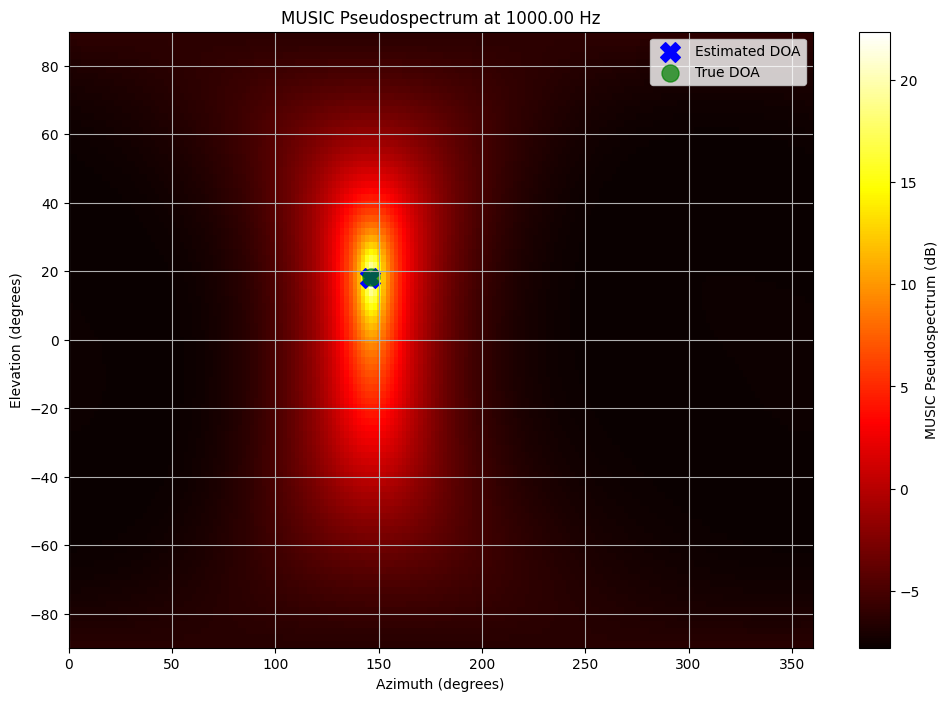


--- Summary of Results ---
What sound it is: **chirping_birds**
Where it is coming from (Estimated):
  Azimuth Angle: **146°** (angle in XY plane from positive X-axis)
  Elevation (Angle of Arrival/DOA): **18°** (angle from XY plane towards Z-axis)
  (Note: 3D position is plotted assuming the true source's distance for visualization.)


In [ ]:
# --- Plotting the MUSIC Pseudospectrum ---
plt.figure(figsize=(12, 8))
log_music_spectrum = 10 * np.log10(np.nan_to_num(music_spectrum, posinf=1e10))
log_music_spectrum[log_music_spectrum == -np.inf] = log_music_spectrum[np.isfinite(log_music_spectrum)].min()

plt.imshow(
    log_music_spectrum.T,
    extent=[azimuth_deg_range.min(), azimuth_deg_range.max(),
            elevation_deg_range.min(), elevation_deg_range.max()],
    origin='lower', aspect='auto', cmap='hot'
)
plt.colorbar(label='MUSIC Pseudospectrum (dB)')
plt.title(f'MUSIC Pseudospectrum at {freq_for_music:.2f} Hz')
plt.xlabel('Azimuth (degrees)')
plt.ylabel('Elevation (degrees)')
plt.grid(True)
plt.scatter(estimated_azimuth_deg, estimated_elevation_deg, color='blue', marker='X', s=200, label='Estimated DOA')
plt.scatter(true_azimuth_deg, true_elevation_deg, color='green', marker='o', s=150, alpha=0.7, label='True DOA')
plt.legend()
plt.show()


# --- 3D Plotting of Microphones and Estimated Sound Source ---

fig_3d = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

fig_3d.add_trace(go.Scatter3d(
    x=mic_array_coords[0,:], y=mic_array_coords[1,:], z=mic_array_coords[2,:],
    mode='markers',
    marker=dict(size=6, color='blue', symbol='circle'),
    name='Microphone Array'
))

fig_3d.add_trace(go.Scatter3d(
    x=[source_pos[0]], y=[source_pos[1]], z=[source_pos[2]],
    mode='markers',
    marker=dict(size=10, color='green', symbol='square'),
    name='True Sound Source'
))

estimated_r = np.linalg.norm(source_pos - array_center_for_steering)

est_az_rad = np.deg2rad(estimated_azimuth_deg)
est_el_rad = np.deg2rad(estimated_elevation_deg)

est_x_rel = estimated_r * np.cos(est_el_rad) * np.cos(est_az_rad)
est_y_rel = estimated_r * np.cos(est_el_rad) * np.sin(est_az_rad)
est_z_rel = estimated_r * np.sin(est_el_rad)

est_x_abs = est_x_rel + room_center[0]
est_y_abs = est_y_rel + room_center[1]
est_z_abs = est_z_rel + mic_height

fig_3d.add_trace(go.Scatter3d(
    x=[est_x_abs],
    y=[est_y_abs],
    z=[est_z_abs],
    mode='markers',
    marker=dict(size=10, color='red', symbol='diamond'),
    name=f'Estimated Sound Source: {predicted_sound_type}'
))

fig_3d.add_trace(go.Scatter3d(
    x=[room_center[0], est_x_abs],
    y=[room_center[1], est_y_abs],
    z=[mic_height, est_z_abs],
    mode='lines',
    line=dict(color='orange', width=3),
    name=f'DOA Vector'
))

fig_3d.update_layout(
    title='3D Sound Source Localization (Simulated Data)',
    scene=dict(
        xaxis_title='X (meters)',
        yaxis_title='Y (meters)',
        zaxis_title='Z (meters)',
        aspectmode='cube',
        xaxis=dict(range=[0, room_dim[0]]),
        yaxis=dict(range=[0, room_dim[1]]),
        zaxis=dict(range=[0, room_dim[2]]),
    ),
    height=700,
    width=900
)
fig_3d.show()

print(f"\n--- Summary of Results ---")
print(f"What sound it is: **{predicted_sound_type}**")
print(f"Where it is coming from (Estimated):")
print(f"  Azimuth Angle: **{estimated_azimuth_deg}°** (angle in XY plane from positive X-axis)")
print(f"  Elevation (Angle of Arrival/DOA): **{estimated_elevation_deg}°** (angle from XY plane towards Z-axis)")
print(f"  (Note: 3D position is plotted assuming the true source's distance for visualization.)")

# Task
Push the current Colab notebook to a specified GitHub repository.

## Authenticate with github

### Subtask:
Generate a GitHub Personal Access Token (PAT) with the necessary permissions and store it securely in Colab.


**Reasoning**:
The subtask requires generating a GitHub PAT and storing it as a Colab secret. This is a manual process that cannot be automated with code. The final step of the instructions is to access the stored secret in a code cell. I will provide the code to access the secret, assuming the user has completed the manual steps of generating and storing the token.



In [1]:
from google.colab import userdata
import os

# Assume the user has manually generated and stored the GITHUB_TOKEN secret in Colab
github_token = userdata.get('GITHUB_TOKEN')

# Verify that the token is loaded (optional, but good for debugging)
if github_token:
    print("GitHub token successfully loaded from Colab secrets.")
    # You might want to do something with the token here,
    # like setting it as an environment variable for git commands
    os.environ['GITHUB_TOKEN'] = github_token
else:
    print("ERROR: GitHub token not found in Colab secrets. Please follow the instructions to add it.")


SecretNotFoundError: Secret GITHUB_TOKEN does not exist.

## Authenticate with github

### Subtask:
Retry Authenticate with github. Generate a GitHub Personal Access Token (PAT) with the necessary permissions and store it securely in Colab.


**Reasoning**:
The previous attempt failed because the `GITHUB_TOKEN` secret was not found in Colab. This subtask requires manual steps from the user to generate and store the token. Since I cannot perform these manual steps, I need to inform the user about the required manual actions and then finish the task, as instructed.



In [2]:
print("This subtask requires manual steps to generate a GitHub Personal Access Token (PAT) and store it as a Colab secret.")
print("Please follow these instructions:")
print("1. Go to your GitHub account settings in a web browser.")
print("2. Navigate to 'Developer settings' -> 'Personal access tokens' -> 'Tokens (classic)'.")
print("3. Click 'Generate new token (classic)'.")
print("4. Give your token a descriptive name (e.g., 'Colab_Notebook_Push').")
print("5. Set an expiration date for the token (recommended).")
print("6. Under 'Select scopes', check the 'repo' checkbox.")
print("7. Click 'Generate token' and COPY the token immediately.")
print("8. In Colab, click the 'Secrets' tab (key icon) on the left sidebar.")
print("9. Click '+ New secret'.")
print("10. Enter 'GITHUB_TOKEN' for the Name and paste the copied token for the Value.")
print("11. Ensure 'Notebook access' is enabled for this notebook.")
print("Once the secret is stored, you can re-run the cell that failed previously or the next cell that attempts to use the token.")

This subtask requires manual steps to generate a GitHub Personal Access Token (PAT) and store it as a Colab secret.
Please follow these instructions:
1. Go to your GitHub account settings in a web browser.
2. Navigate to 'Developer settings' -> 'Personal access tokens' -> 'Tokens (classic)'.
3. Click 'Generate new token (classic)'.
4. Give your token a descriptive name (e.g., 'Colab_Notebook_Push').
5. Set an expiration date for the token (recommended).
6. Under 'Select scopes', check the 'repo' checkbox.
7. Click 'Generate token' and COPY the token immediately.
8. In Colab, click the 'Secrets' tab (key icon) on the left sidebar.
9. Click '+ New secret'.
10. Enter 'GITHUB_TOKEN' for the Name and paste the copied token for the Value.
11. Ensure 'Notebook access' is enabled for this notebook.
Once the secret is stored, you can re-run the cell that failed previously or the next cell that attempts to use the token.
